In [86]:
import matplotlib.pyplot as plt
import numpy as np

# Chemical Drawing
from rdkit.Chem import MolFromMolBlock, MolToMolFile, MolToPDBFile, AddHs, rdmolops
from rdkit.Chem.AllChem import Compute2DCoords
from rdkit.Chem.Draw import MolToImage
from IPython.display import display

# Lignin-KMC functions and global variables used in this notebook
from ligninkmc.kmc_functions import (run_kmc, generate_mol)
from ligninkmc.create_lignin import (calc_rates, create_initial_monomers, create_initial_events,
                                     create_initial_state, analyze_adj_matrix, adj_analysis_to_stdout)
# from ligninkmc.kmc_common import (ADJ_MATRIX, CHAIN_LEN, RCF_YIELDS, MONO_LIST, MONOMER, OX, GROW, Monomer, Event)
from ligninkmc.kmc_common import (GROW, OX,
                                  MONOMER, OLIGOMER, MONO_LIST, ADJ_MATRIX, BONDS, CHAIN_LEN, RCF_YIELDS, Event, Monomer)

# For performance
import time
#Parallelization
import joblib as par

In [87]:

# making all non-ring linkages 1.0 and increasing oxidation Ea because
# oxidation is needed for the fragments to be activated to link but I want the linking to be faster
# lowest barrier on oligomer-oligomer linking so that long fragments form faster
DEF_E_BARRIER_KCAL_MOL = {'5o4': {(0, 0): {('monomer', 'monomer'): 1.0,
   ('monomer', 'oligomer'): 1.0,
   ('oligomer', 'monomer'): 1.0,
   ('oligomer', 'oligomer'): 0.2},
  (1, 0): {('monomer', 'monomer'): 1.0,
   ('monomer', 'oligomer'): 1.0,
   ('oligomer', 'monomer'): 1.0,
   ('oligomer', 'oligomer'): 0.2},
  (2, 2): {('monomer', 'monomer'): 1.0,
   ('monomer', 'oligomer'): 1.0,
   ('oligomer', 'monomer'): 1.0,
   ('oligomer', 'oligomer'): 0.2}},
 '55': {(0, 0): {('monomer', 'monomer'): 1.0,
   ('monomer', 'oligomer'): 1.0,
   ('oligomer', 'monomer'): 1.0,
   ('oligomer', 'oligomer'): 0.2},
  (2, 2): {('monomer', 'monomer'): 1.0,
   ('monomer', 'oligomer'): 1.0,
   ('oligomer', 'monomer'): 1.0,
   ('oligomer', 'oligomer'): 0.2}},
 'b5': {(0, 0): {('monomer', 'monomer'): 20.7,
   ('monomer', 'oligomer'): 20.7,
   ('oligomer', 'monomer'): 20.7,
   ('oligomer', 'oligomer'): 20.7},
  (0, 1): {('monomer', 'monomer'): 20.7,
   ('monomer', 'oligomer'): 20.7,
   ('oligomer', 'monomer'): 20.7,
   ('oligomer', 'oligomer'): 20.7},
  (2, 2): {('monomer', 'monomer'): 20.7,
   ('monomer', 'oligomer'): 20.7,
   ('oligomer', 'monomer'): 20.7,
   ('oligomer', 'oligomer'): 20.7}},
 'bb': {(0, 0): {('monomer', 'monomer'): 20.7,
   ('monomer', 'oligomer'): 20.7,
   ('oligomer', 'monomer'): 20.7,
   ('oligomer', 'oligomer'): 20.7},
  (1, 0): {('monomer', 'monomer'): 20.7,
   ('monomer', 'oligomer'): 20.7,
   ('oligomer', 'monomer'): 20.7,
   ('oligomer', 'oligomer'): 20.7},
  (0, 1): {('monomer', 'monomer'): 20.7,
   ('monomer', 'oligomer'): 20.7,
   ('oligomer', 'monomer'): 20.7,
   ('oligomer', 'oligomer'): 20.7},
  (1, 1): {('monomer', 'monomer'): 20.7,
   ('monomer', 'oligomer'): 20.7,
   ('oligomer', 'monomer'): 20.7,
   ('oligomer', 'oligomer'): 20.7},
  (2, 2): {('monomer', 'monomer'): 20.7,
   ('monomer', 'oligomer'): 20.7,
   ('oligomer', 'monomer'): 20.7,
   ('oligomer', 'oligomer'): 20.7}},
 'bo4': {(0, 0): {('monomer', 'monomer'): 1.0,
   ('monomer', 'oligomer'): 1.0,
   ('oligomer', 'monomer'): 1.0,
   ('oligomer', 'oligomer'): 0.2},
  (1, 0): {('monomer', 'monomer'): 1.0,
   ('monomer', 'oligomer'): 1.0,
   ('oligomer', 'monomer'): 1.0,
   ('oligomer', 'oligomer'): 1.0},
  (0, 1): {('monomer', 'monomer'): 1.0,
   ('monomer', 'oligomer'): 1.0,
   ('oligomer', 'monomer'): 1.0,
   ('oligomer', 'oligomer'): 0.2},
  (1, 1): {('monomer', 'monomer'): 1.0,
   ('monomer', 'oligomer'): 1.0,
   ('oligomer', 'monomer'): 1.0,
   ('oligomer', 'oligomer'): 0.2},
  (2, 2): {('monomer', 'monomer'): 1.0,
   ('monomer', 'oligomer'): 1.0,
   ('oligomer', 'monomer'): 1.0,
   ('oligomer', 'oligomer'): 0.2}},
 'ao4': {(0, 0): {('monomer', 'monomer'): 1.0,
   ('monomer', 'oligomer'): 1.0,
   ('oligomer', 'monomer'): 1.0,
   ('oligomer', 'oligomer'): 0.2},
  (1, 0): {('monomer', 'monomer'): 1.0,
   ('monomer', 'oligomer'): 1.0,
   ('oligomer', 'monomer'): 1.0,
   ('oligomer', 'oligomer'): 0.2},
  (0, 1): {('monomer', 'monomer'): 1.0,
   ('monomer', 'oligomer'): 1.0,
   ('oligomer', 'monomer'): 1.0,
   ('oligomer', 'oligomer'): 0.2},
  (1, 1): {('monomer', 'monomer'): 1.0,
   ('monomer', 'oligomer'): 1.0,
   ('oligomer', 'monomer'): 1.0,
   ('oligomer', 'oligomer'): 0.2},
  (2, 2): {('monomer', 'monomer'): 1.0,
   ('monomer', 'oligomer'): 1.0,
   ('oligomer', 'monomer'): 1.0,
   ('oligomer', 'oligomer'): 0.2}},
#  'b1': {(0, 0): {('monomer', 'oligomer'): 9.6,
#    ('oligomer', 'monomer'): 9.6,
#    ('oligomer', 'oligomer'): 9.6},
#   (1, 0): {('monomer', 'oligomer'): 11.7,
#    ('oligomer', 'monomer'): 11.7,
#    ('oligomer', 'oligomer'): 11.7},
#   (0, 1): {('monomer', 'oligomer'): 10.7,
#    ('oligomer', 'monomer'): 10.7,
#    ('oligomer', 'oligomer'): 10.7},
#   (1, 1): {('monomer', 'oligomer'): 11.9,
#    ('oligomer', 'monomer'): 11.9,
#    ('oligomer', 'oligomer'): 11.9},
#   (2, 2): {('monomer', 'oligomer'): 9.6,
#    ('oligomer', 'monomer'): 9.6,
#    ('oligomer', 'oligomer'): 9.6}},
 'b1': {(0, 0): {('monomer', 'oligomer'): 20.7,
   ('oligomer', 'monomer'): 20.7,
   ('oligomer', 'oligomer'): 20.7},
  (1, 0): {('monomer', 'oligomer'): 20.7,
   ('oligomer', 'monomer'): 20.7,
   ('oligomer', 'oligomer'): 20.7},
  (0, 1): {('monomer', 'oligomer'): 20.7,
   ('oligomer', 'monomer'): 20.7,
   ('oligomer', 'oligomer'): 20.7},
  (1, 1): {('monomer', 'oligomer'): 20.7,
   ('oligomer', 'monomer'): 20.7,
   ('oligomer', 'oligomer'): 20.7},
  (2, 2): {('monomer', 'oligomer'): 20.7,
   ('oligomer', 'monomer'): 20.7,
   ('oligomer', 'oligomer'): 20.7}},
 'oxidation': {0: {'monomer': 2.5, 'oligomer': 2.5},
  1: {'monomer': 2.5, 'oligomer': 2.5},
  2: {'monomer': 2.5, 'oligomer': 2.5}},
#  'hydration': {0: {'monomer': 11.1, 'oligomer': 11.1},
#   1: {'monomer': 11.7, 'oligomer': 11.7},
#   2: {'monomer': 11.1, 'oligomer': 11.1}}} 
 'hydration': {0: {'monomer': 5.0, 'oligomer': 5.0},
  1: {'monomer': 5.0, 'oligomer': 5.0},
  2: {'monomer': 5.0, 'oligomer': 5.0}}} 
#  'hydration': {0: {'monomer': 20.7, 'oligomer': 20.7},
#   1: {'monomer': 20.7, 'oligomer': 20.7},
#   2: {'monomer': 20.7, 'oligomer': 20.7}}}
#  'hydration': {0: {'monomer': 0.1, 'oligomer': 0.1},
#   1: {'monomer': 0.1, 'oligomer': 0.1},
#   2: {'monomer': 0.1, 'oligomer': 0.1}}}



### Lignin with mostly B-O-4 bonds only

In [88]:
# save_dir = "/Users/exequielpunzalan/2019SumProj/structure_files/sample_cases/lignin-kmc/01132020"
save_dir = "/home/tgog/conformer-ml/ligninsavedir"

# Calculate the rates of reaction in 1/s (or 1/monomer-s if biomolecular) at the specified temp
temp = 298.15  # K
rxn_rates = calc_rates(temp, ea_kcal_mol_dict=DEF_E_BARRIER_KCAL_MOL)

In [89]:
# sg_opts = [0.1, 0.2, 0.25, 0.33, 0.5, 1, 2, 3, 4, 5, 10]
sg_opts = [1]
# num_repeats = 5
num_monos_list = [2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9]
lignin_oligomers = []

fun = par.delayed(run_kmc)
sg_result_list = []

for sg_ratio in sg_opts:
    for num_monos in num_monos_list:
        intact = False
        while not intact:
            # Set the percentage of S
            pct_s = sg_ratio / (1 + sg_ratio)

            # Make choices about what kinds of monomers there are and create them
            monomer_draw = np.random.rand(num_monos)
            initial_monomers = create_initial_monomers(pct_s, monomer_draw)

            # Initialize the monomers, events, and state
            mono_add_rate = 1e2
            initial_events = create_initial_events(initial_monomers, rxn_rates)
            initial_events.append(Event(GROW, [], rate=mono_add_rate))
            initial_state = create_initial_state(initial_events, initial_monomers)

    #         result = par.Parallel(n_jobs=4)([fun(rxn_rates, initial_state, initial_events, n_max=num_monos, t_max=1)
    #                                           for _ in range(num_repeats)])

            result = run_kmc(rxn_rates, initial_state, initial_events, n_max=num_monos, t_max=1, sg_ratio=sg_ratio)

            # using RDKit to save Molecule
            nodes = result[MONO_LIST]
            adj = result[ADJ_MATRIX]
            block = generate_mol(adj, nodes)
            mol = MolFromMolBlock(block) # still with H's
            
            frags = rdmolops.GetMolFrags(mol)
            if len(frags) == 1:
                intact = True
            else:
                continue
            
            lignin_oligomers.append(mol)
            # save
            MolToMolFile(mol, save_dir + f"/{sg_ratio}sgr_{pct_s}pctS_{num_monos}monomers.mol")
            MolToPDBFile(mol, save_dir + f"/{sg_ratio}sgr_{pct_s}pctS_{num_monos}monomers.pdb")

            sg_result_list.append(result)
    
    t = time.localtime()
    print('Completed sensitivity iteration for S to G ratio {:5.2f} on '
          '{}-{:02d}-{:02d} at {:02d}:{:02d}:{:02d}'.format(sg_ratio, t.tm_year, t.tm_mon, t.tm_mday,
                                                            t.tm_hour, t.tm_min, t.tm_sec))

Completed sensitivity iteration for S to G ratio  1.00 on 2020-04-11 at 21:11:10


In [90]:
len(lignin_oligomers)

15

In [91]:
from rdkit.Chem import MolToSmiles, MolFromSmiles

new_ligs = []
for idx, lig in enumerate(lignin_oligomers):
    
    smiles = MolToSmiles(lig)
    smiles = smiles.replace('[O]', 'O')
    new_lig = MolFromSmiles(smiles)
    
    new_ligs.append(new_lig)
lignin_oligomers = new_ligs

Number of monomers: 2


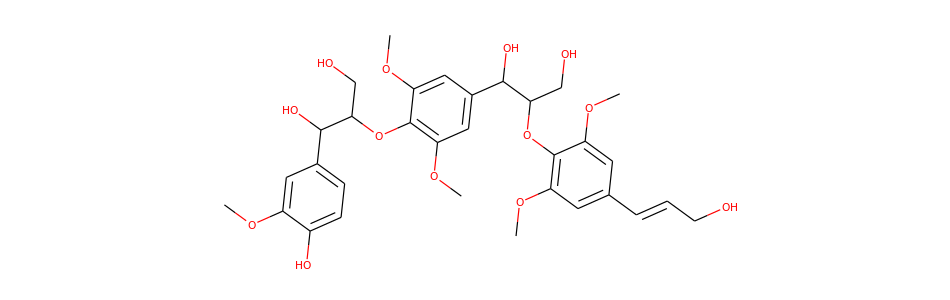

In [78]:
# display 2D
mol = lignin_oligomers[0]

print(f"Number of monomers: {num_monos_list[0]}")
Compute2DCoords(mol)
display(MolToImage(mol, size=(950, 300)))

Number of monomers: 3


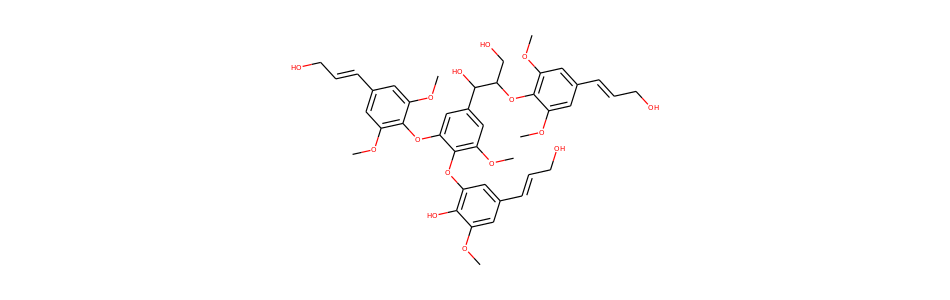

In [79]:
# display 2D
mol = lignin_oligomers[1]

print(f"Number of monomers: {num_monos_list[1]}")
Compute2DCoords(mol)
display(MolToImage(mol, size=(950, 300)))

Number of monomers: 4


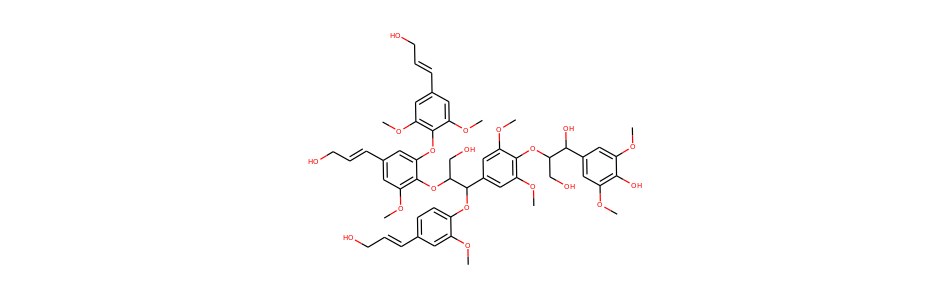

In [80]:
# display 2D
mol = lignin_oligomers[2]

print(f"Number of monomers: {num_monos_list[2]}")
Compute2DCoords(mol)
display(MolToImage(mol, size=(950, 300)))

Number of monomers: 5


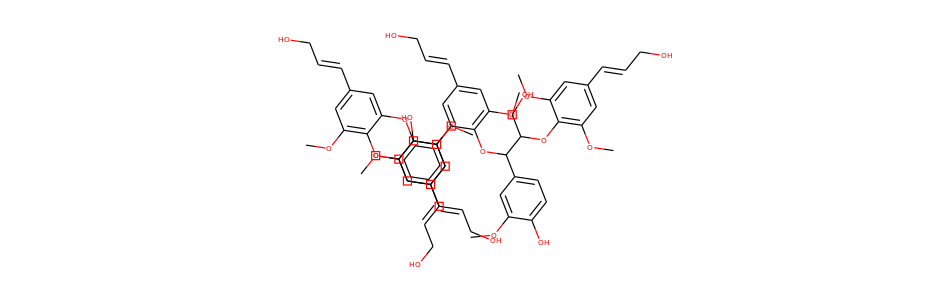

In [81]:
# display 2D
mol = lignin_oligomers[3]

print(f"Number of monomers: {num_monos_list[3]}")
Compute2DCoords(mol)
display(MolToImage(mol, size=(950, 300)))

Number of monomers: 6


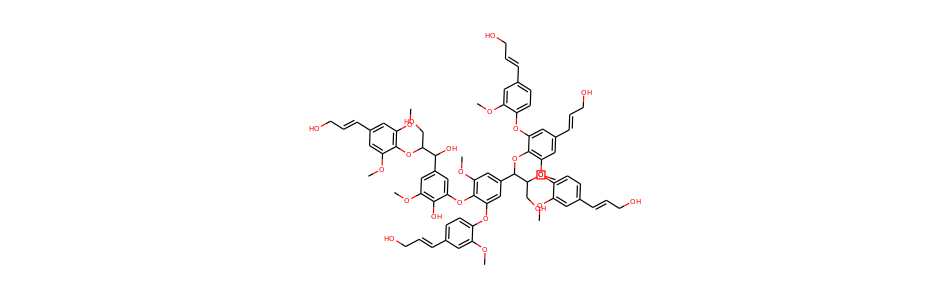

In [82]:
# display 2D
mol = lignin_oligomers[4]

print(f"Number of monomers: {num_monos_list[4]}")
Compute2DCoords(mol)
display(MolToImage(mol, size=(950, 300)))

Number of monomers: 7


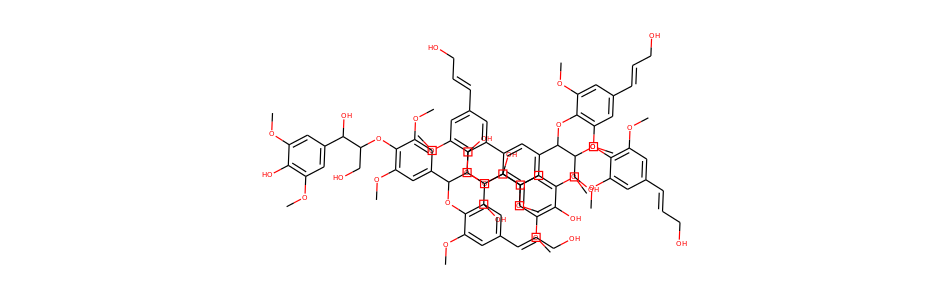

In [83]:
# display 2D
mol = lignin_oligomers[5]
print(f"Number of monomers: {num_monos_list[5]}")
Compute2DCoords(mol)
display(MolToImage(mol, size=(950, 300)))

In [84]:
import py3Dmol
from rdkit import Chem
from utils import *

confgen = ConformerGeneratorCustom(max_conformers=1, 
                 rmsd_threshold=None, 
                 force_field='mmff',
                 pool_multiplier=1)


def drawit(m, p, confId=-1):
    mb = Chem.MolToMolBlock(m, confId=confId)
    p.removeAllModels()
    p.addModel(mb, "sdf")
    p.setStyle({"stick":{}})
    p.setBackgroundColor("0xeeeeee")
    p.zoomTo()
    return p.show()


In [70]:
from rdkit.Chem import MolToSmiles, MolFromSmiles
MolToSmiles(lignin_oligomers[0])

'COc1cc(C(O)C(CO)Oc2c(OC)cc(C(O)C(CO)Oc3c(OC)cc(/C=C/CO)cc3OC)cc2OC)ccc1O'

In [71]:
assert '[O]' not in MolToSmiles(lignin_oligomers[0])

In [72]:
mol = lignin_oligomers[0]

mol = Chem.AddHs(mol)
res = AllChem.EmbedMultipleConfs(mol, numConfs=1, numThreads=-1)
res = AllChem.MMFFOptimizeMoleculeConfs(mol, numThreads=-1)

p = py3Dmol.view(width=800, height=800)
drawit(mol, p, confId=0)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [73]:
mol = lignin_oligomers[1]

mol = Chem.AddHs(mol)
res = AllChem.EmbedMultipleConfs(mol, numConfs=1, numThreads=-1)
res = AllChem.MMFFOptimizeMoleculeConfs(mol, numThreads=-1)

p = py3Dmol.view(width=800, height=800)
drawit(mol, p, confId=0)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [74]:
mol = lignin_oligomers[2]

mol = Chem.AddHs(mol)
res = AllChem.EmbedMultipleConfs(mol, numConfs=1, numThreads=-1)
# res = AllChem.MMFFOptimizeMoleculeConfs(mol, numThreads=-1)

p = py3Dmol.view(width=800, height=800)
drawit(mol, p, confId=0)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [75]:
mol = lignin_oligomers[3]

mol = Chem.AddHs(mol)
res = AllChem.EmbedMultipleConfs(mol, numConfs=1, numThreads=-1)
res = AllChem.MMFFOptimizeMoleculeConfs(mol, numThreads=-1)

p = py3Dmol.view(width=800, height=800)
drawit(mol, p, confId=0)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [76]:
mol = lignin_oligomers[4]

mol = Chem.AddHs(mol)
res = AllChem.EmbedMultipleConfs(mol, numConfs=1, numThreads=-1)
res = AllChem.MMFFOptimizeMoleculeConfs(mol, numThreads=-1)

p = py3Dmol.view(width=800, height=800)
drawit(mol, p, confId=0)

ValueError: Bad Conformer Id

In [77]:
mol = lignin_oligomers[5]

mol = Chem.AddHs(mol)
res = AllChem.EmbedMultipleConfs(mol, numConfs=1, numThreads=-1)
res = AllChem.MMFFOptimizeMoleculeConfs(mol, numThreads=-1)

p = py3Dmol.view(width=800, height=800)
drawit(mol, p, confId=0)

ValueError: Bad Conformer Id

In [ ]:
from rdkit.Chem import MolFromMolFile

mol = MolFromMolFile('out.mol')
p = py3Dmol.view(width=800, height=800)
drawit(mol, p, confId=0)

In [20]:
print(len(TorsionFingerprints.CalculateTorsionLists(lignin_oligomers[0])[0]))

43


In [92]:
lignin_oligomers

In [93]:
from rdkit import Chem
import os

import json
from tempfile import TemporaryDirectory
import subprocess

from utils import *

def save_lignins_obabel(i, smiles):
    print('got here')
    init_dir = os.getcwd()
    print('got here')
    with TemporaryDirectory() as td:
        os.chdir(td)
        
        with open('testing.smi', 'w') as fp:
            fp.write(smiles)
            
        subprocess.check_output('obabel testing.smi -O initial.sdf --gen3d --fast', shell=True)
        subprocess.check_output('obabel initial.sdf -O confs.sdf --confab --conf 200 --ecutoff 100000000.0 --rcutoff 0.001', shell=True)
    
        inp = load_from_sdf('confs.sdf')
        mol = inp[0]
        for confmol in inp[1:]:
            c = confmol.GetConformer(id=0)
            mol.AddConformer(c, assignId=True)

        res = AllChem.MMFFOptimizeMoleculeConfs(mol, numThreads=-1)
        mol = prune_conformers(mol, 0.05)
        
        energys = confgen.get_conformer_energies(mol) * 0.25
        standard = energys.min()
        total = np.sum(np.exp(-(energys-standard)))
        
        Chem.MolToMolFile(mol, f'{init_dir}/lignin_ob_hightemp_h_fixed/{num_monos_list[i]}_{i}.mol')
    
    os.chdir(init_dir)
    
    out = {
        'molfile': f'{num_monos_list[i]}_{i}.mol',
        'standard': standard,
        'total': total,
    }
    
    with open(f'lignin_ob_hightemp_h_fixed/{num_monos_list[i]}_{i}.json', 'w') as fp:
        json.dump(out, fp)
    
for i, lo in enumerate(lignin_oligomers):
    mol = Chem.AddHs(lo)
    smiles = Chem.MolToSmiles(mol)
    print(i)
    save_lignins_obabel(i, Chem.MolToSmiles(mol))

0
got here
got here
1
got here
got here
2
got here
got here
3
got here
got here
4
got here
got here
5
got here
got here
6
got here
got here
7
got here
got here
8
got here
got here
9
got here
got here
10
got here
got here
11
got here
got here
12
got here
got here
13
got here
got here
14
got here
got here


In [81]:
from rdkit import Chem
import os

import json
from tempfile import TemporaryDirectory
import subprocess

from concurrent.futures import ProcessPoolExecutor    

from utils import *

def rotate(mol):
    nonring, ring = TorsionFingerprints.CalculateTorsionLists(mol)
    conf = mol.GetConformer(id=0)
    
    action = np.random.randint(6, size=len(nonring))
    
    for idx, tors in enumerate(nonring):
        tors = tors[0][0]
        ang = -180.0 + 60 * action[idx]
        Chem.rdMolTransforms.SetDihedralDeg(conf, tors[0], tors[1], tors[2], tors[3], float(ang))
        
    return mol

def save_lignins_obabel_randomized(i, smiles):
    init_dir = os.getcwd()
    with TemporaryDirectory() as td:
        os.chdir(td)
        
        with open('testing.smi', 'w') as fp:
            fp.write(smiles)
            
        subprocess.check_output('obabel testing.smi -O initial.sdf --gen3d --fast', shell=True)
        
        inp = load_from_sdf('initial.sdf')
        mol = inp[0]
    os.chdir(init_dir)
    
    res = AllChem.MMFFOptimizeMoleculeConfs(mol, numThreads=-1) 
    
    with ProcessPoolExecutor() as executor:
        allmols = executor.map(rotate, [Chem.Mol(mol) for i in range(199)])


    for confmol in allmols:
        c = confmol.GetConformer(id=0)
        mol.AddConformer(c, assignId=True)

    res = AllChem.MMFFOptimizeMoleculeConfs(mol, numThreads=-1)
    return mol

    #         print(mol.GetNumConformers())
#         mol = prune_conformers(mol, 0.05)
#         print(mol.GetNumConformers())
    energys = confgen.get_conformer_energies(mol) * 0.25
    print(energys)
    standard = energys.min()
    total = np.sum(np.exp(-(energys-standard)))

    
    Chem.MolToMolFile(mol, f'lignin_random_out_low_temp/{num_monos_list[i]}_{i}.mol')
    
    out = {
        'molfile': f'{num_monos_list[i]}_{i}.mol',
        'standard': standard,
        'total': total,
    }
    
    with open(f'lignin_random_out_low_temp/{num_monos_list[i]}_{i}.json', 'w') as fp:
        json.dump(out, fp)
    
for i, lo in enumerate(lignin_oligomers):
    mol = Chem.AddHs(lo)
    smiles = Chem.MolToSmiles(mol)
    print(i)
    mol = save_lignins_obabel_randomized(i, Chem.MolToSmiles(mol))
    break

0


In [8]:
import pickle

with open('trained_mol.pickle', 'rb') as p:
    mol = pickle.load(p)

In [9]:
p = py3Dmol.view(width=800, height=800)
drawit(mol, p, confId=136)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [10]:
mol.GetNumAtoms()

232

In [11]:
from utils import prune_conformers, print_torsions

print(mol.GetNumConformers())
mol = prune_conformers(mol, 0.05)
print(mol.GetNumConformers())


199
137


In [14]:
# energys = confgen.get_conformer_energies(mol) * 0.25

energys = confgen.get_conformer_energies(mol)
total = np.sum(np.exp(-(energys- 7.668625034772399)))
print(total / 13.263723987526067)
print(np.argsort(energys))


1.0553216683428206
[  0   3   2   4   1   5   6   8  13  15  10   7  12  14  17   9  16  18
  21  34  36  29  43  27  47  46  11  49  19  25  23  20  30  24  22  26
  35  63  37  38  40  33  28  44  39  42  45  31  48  62  65  32  54  66
  58  57  50  55  84  70  53  64  59  69  51  67  79  73  88  90  74  82
  41  52  61  76  93  89  60  83  71  72  68  75  97  56  77 104  81  78
 117  91  94 100 101  85 107 106 105  87 124 121  99 109  98 102 126  95
 115 108 120 110 103 119  80  92 123 113 116  86 122  96 112 114 125 128
 127 111 118 130 134 129 131 132 133 135 136]


In [ ]:
import pickle

with open('test_mol.pickle', 'rb') as p:
    test = pickle.load(p)
energys = confgen.get_conformer_energies(test) * 0.25
total = np.sum(np.exp(-(energys- 144.28859671479884)))
print(total / 1.1496334868660132)
print(np.argsort(energys))

p = py3Dmol.view(width=800, height=800)
drawit(mol, p, confId=118)

In [79]:
def translate_to_discrete(deg):
    deg = round(deg)

    if deg <= -150 or deg > 150:
        return 0
    if deg <= 150 and deg > 90:
        return 1
    if deg <= 150 and deg > 30:
        return 2        
    if deg <= 30 and deg > -30:
        return 3      
    if deg <= -30 and deg > -90:
        return 4    
    if deg <= -90 and deg > -150:
        return 5   

def print_torsion(mol, ID=0):
    nonring, ring = TorsionFingerprints.CalculateTorsionLists(mol)
    conf = mol.GetConformer(id=ID)
    tups = [atoms[0] for atoms, ang in nonring]
    degs = [Chem.rdMolTransforms.GetDihedralDeg(conf, *tup) for tup in tups]
    return degs    
    
def print_torsion_buckets(mol, ID=0):
    nonring, ring = TorsionFingerprints.CalculateTorsionLists(mol)
    conf = mol.GetConformer(id=ID)
    tups = [atoms[0] for atoms, ang in nonring]
    degs = [translate_to_discrete(Chem.rdMolTransforms.GetDihedralDeg(conf, *tup)) for tup in tups]
    return degs

print(print_torsion_buckets(mol, 2))
print(print_torsion_buckets(mol, 78))


[1, 0, 2, 0, 4, 4, 4, 4, 5, 4, 2, 4, 4, 5, 4, 3, 5, 3, 5, 1, 2, 1, 2, 2, 0, 2, 2, 4, 0, 1, 4, 3, 5, 1, 2, 0, 5, 0, 5, 4, 0, 4, 4, 1, 2, 1, 0, 3, 5, 1, 3, 3, 0, 3, 3, 4]
[1, 3, 5, 1, 1, 5, 5, 1, 5, 4, 2, 1, 4, 0, 2, 0, 1, 2, 1, 4, 3, 3, 2, 1, 0, 0, 4, 2, 2, 2, 4, 0, 5, 3, 0, 0, 3, 5, 1, 0, 4, 3, 2, 2, 1, 4, 3, 5, 4, 4, 0, 5, 0, 3, 4, 4]


In [ ]:
print_torsions()

In [72]:
print(degs2)

[115.9966719643282, -0.35493573667512385, -104.76629410900014, 119.26662380407744, 109.67374089147343, -138.96901138104766, -149.08680483890123, 143.71177780363723, -124.27638858001083, -74.77826837066918, 78.87930153069313, 118.4938740952548, -45.39590234528357, 170.66428393864135, 70.86966098647122, 179.02209952951947, 118.41854016281884, 76.4806994985924, 120.06161324815533, -68.95746189684893, -15.980412572098269, -0.36689251977403137, 82.2198546328986, 130.78085031061713, 173.2504101370801, 165.3548790906494, -58.74464765817024, 53.29618293004646, 52.7246916982817, 74.84840908917282, -65.52524363402813, -175.98163845744347, -120.23318110691326, -27.823819736068494, -154.54613679208225, -179.18329657464645, 8.508760919156012, -106.75877416709, 149.37554605001324, 157.30600166057786, -63.96734374706033, 1.3874201030379136, 59.68476907178398, 53.52694495673112, 116.44876701710112, -66.99829993640721, 4.201390256882817, -106.20767615802647, -41.98183674719473, -39.24134588160243, 178.

In [32]:
energys.sort()
total = np.sum(np.exp(-(energys[:10]- 144.28859671479884)))
print(total / 1.1496334868660132)

465962.25113189773


In [90]:
import pickle

mol = Chem.MolFromMolFile('lignin_obabel_out_low_temp/7_0.mol')
mol = Chem.AddHs(mol)
res = AllChem.MMFFOptimizeMoleculeConfs(mol, numThreads=-1)
p = py3Dmol.view(width=800, height=800)
drawit(mol, p, confId=0)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [80]:
os.chdir('/home/tgog/conformer-ml')

In [23]:
import json
def save_lignins(i, smiles, standard, total):
    
    out = {
        'mol': smiles,
        'standard': standard,
        'total': total,
    }
    
    with open(f'lignins_out_high_temp/{num_monos_list[i]}_{i}.json', 'w') as fp:
        json.dump(out, fp)
    
for i, lo in enumerate(lignin_oligomers):
    mol = Chem.AddHs(lo)
    res = AllChem.EmbedMultipleConfs(mol, numConfs=200, numThreads=-1)
    res = AllChem.MMFFOptimizeMoleculeConfs(mol, numThreads=-1)
    
    energys = confgen.get_conformer_energies(mol) * 0.25
    standard = energys.min()
    total = np.sum(np.exp(-(energys-standard)))    
    print(standard, total)
    save_lignins(i, Chem.MolToSmiles(mol), standard, total)
    

34.56112047593297 20.24483664501715
38.63002422076991 21.858390691044434
51.53737117768082 10.62099313981785
64.71910045533441 19.834404536818056
46.154418513343586 21.449193041937075
62.82653315084233 11.583301033973207


In [ ]:
import json
def save_lignins_adaptive(i, smiles, standard, total, inv_temp):
    
    out = {
        'mol': smiles,
        'standard': standard,
        'total': total,
        'inv_temp': inv_temp,
    }
    
    with open(f'lignins_out_adaptive_temp/{num_monos_list[i]}_{i}.json', 'w') as fp:
        json.dump(out, fp)
    
for i, lo in enumerate(lignin_oligomers):
    mol = Chem.AddHs(lo)
    res = AllChem.EmbedMultipleConfs(mol, numConfs=200, numThreads=-1)
    res = AllChem.MMFFOptimizeMoleculeConfs(mol, numThreads=-1)
    
    energys = confgen.get_conformer_energies(mol)
    standard = energys.min()
    inv_temp = 50.0 / standard
    energys *= inv_temp
    standard = energys.min()
    total = np.sum(np.exp(-(energys-standard)))    
    print(standard, total)
    save_lignins_adaptive(i, Chem.MolToSmiles(mol), standard, total, inv_temp)
    

In [ ]:
import json
from rdkit.Chem import AllChem

with open(f'lignins_out_low_temp/2_0.json') as fp:
    out = json.load(fp)
    
lo = Chem.MolFromSmiles(out['mol'])
mol = Chem.AddHs(lo)
# res = AllChem.EmbedMultipleConfs(mol, numConfs=1, numThreads=-1)
# res = AllChem.MMFFOptimizeMoleculeConfs(mol, numThreads=-1)

# energys = confgen.get_conformer_energies(mol) * 0.25
# standard = energys.min()
# total = np.sum(np.exp(-(energys-standard)))    
# print(standard)
# print(total)
# p = py3Dmol.view(width=800, height=800)
# drawit(Chem.RemoveHs(mol), p, confId=0)
filemol = mol

In [ ]:
with open(f'lignins_out/2_1.json') as fp:
    out = json.load(fp)
    print(out['mol'])

In [ ]:
sm = 'COC(=O)C1=C(C)N=c2s/c(=C\c3c(F)cccc3Cl)c(=O)n2[C@H]1c1ccc(OC(=O)c2ccco2)cc1'

mol = Chem.MolFromSmiles(sm)
mol = Chem.AddHs(mol)
res = AllChem.EmbedMultipleConfs(mol, numConfs=1, numThreads=-1)
res = AllChem.MMFFOptimizeMoleculeConfs(mol, numThreads=-1)
p = py3Dmol.view(width=800, height=800)
drawit(mol, p, confId=0)

In [ ]:
print(len(TorsionFingerprints.CalculateTorsionLists(mol)[0]))